### This notebook walks your through reading in the datasets required for your project. All other elements of the notebook are to be designed from you based on what we have learned in the course thus far, including descriptive markdown and best practices.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter
import cftime
import datetime

### Load in decadal-averaged WOA18 datasets using `xr.open_zarr` and extract the `potential_temperature` DataArray. The dataset is broken up by averaged decades (1955 to 1964 average ... and so on), thus it is possible to compare changes across decades if you wish. The `woa18_decav_potential_temp` file contains the time-averaged fields from 1981 to 2010, the "Climate Normal".

In [2]:
woa18_1955_64_potential_temp = xr.open_zarr('../data/woa18/woa18_1955_1964_temperature',decode_times=False).potential_temperature
woa18_1965_74_potential_temp = xr.open_zarr('../data/woa18/woa18_1965_1974_temperature',decode_times=False).potential_temperature
woa18_1975_84_potential_temp = xr.open_zarr('../data/woa18/woa18_1975_1984_temperature',decode_times=False).potential_temperature
woa18_1985_94_potential_temp = xr.open_zarr('../data/woa18/woa18_1985_1994_temperature',decode_times=False).potential_temperature
woa18_1994_04_potential_temp = xr.open_zarr('../data/woa18/woa18_1995_2004_temperature',decode_times=False).potential_temperature
woa18_2005_17_potential_temp = xr.open_zarr('../data/woa18/woa18_2005_2017_temperature',decode_times=False).potential_temperature
woa18_decav_potential_temp = xr.open_zarr('../data/woa18/woa18_decav_temperature',decode_times=False).potential_temperature

In [3]:
woa18_1955_64_potential_temp

<xarray.DataArray 'potential_temperature' (depth: 102, lat: 180, lon: 360)>
dask.array<open_dataset-potential_temperature, shape=(102, 180, 360), dtype=float32, chunksize=(26, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    time     float32 ...
Attributes:
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    standard_name:  sea_water_temperature
    units:          degrees_celsius

### Documentation of the WOA18 product can be found [__here__](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/). You will be expected to be able to speak knowledgeably about the main ways in which we observe the ocean and what the __World Ocean Atlas__ is. Spend some time researching this.

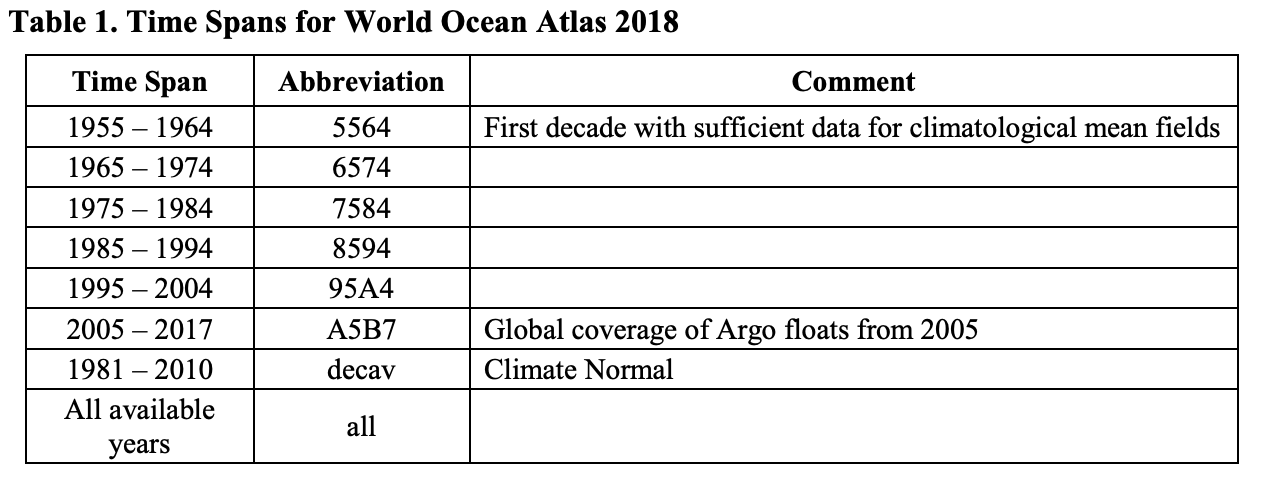

In [4]:
woa18_1955_64_potential_temp

<xarray.DataArray 'potential_temperature' (depth: 102, lat: 180, lon: 360)>
dask.array<open_dataset-potential_temperature, shape=(102, 180, 360), dtype=float32, chunksize=(26, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    time     float32 ...
Attributes:
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    standard_name:  sea_water_temperature
    units:          degrees_celsius

### For analysis at the _basin scale_ you will need the ocean basins mask provided below. This seperates the global ocean into distinct basins identified by integer values such that:
* ### Southern Ocean = 1
* ### Atlantic Ocean = 2
* ### Pacific Ocean = 3
* ### Arctic Ocean = 4
* ### Indian Ocean = 5

In [5]:
woa18_basins = xr.open_dataset('../data/basins/woa18_basins_mask.nc',decode_times=False).mask

In [7]:
woa18_basins

<xarray.DataArray 'mask' (lat: 180, lon: 360)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    time     float32 438.0
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

Text(0.5, 1.0, 'Ocean Basin Mask')

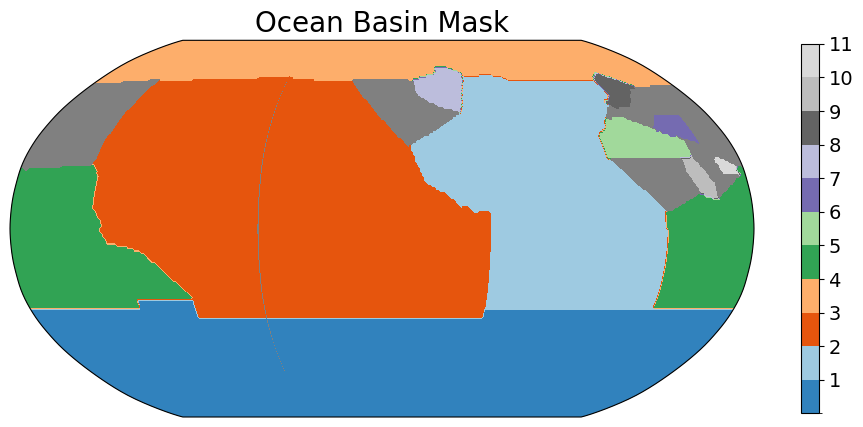

In [6]:
subplot_kws = dict(projection=ccrs.Robinson(central_longitude=-120),facecolor='grey')

plt.figure(figsize=[12,8])

p = woa18_basins.plot.contourf(x='lon',y='lat',
                         cmap='tab20c',
                         vmin=0,vmax=11,levels=12,
                         subplot_kws = subplot_kws,
                         transform=ccrs.PlateCarree(),
                         add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[1,2,3,4,5,6,7,8,9,10,11], shrink=0.6)
cb.ax.tick_params(labelsize=14)
plt.title("Ocean Basin Mask",fontsize=20)

### To isolate the Southern Ocean we can use Xarray's `.where()` method:

In [80]:
southernocean = (woa18_basins.where(woa18_basins==1) /  woa18_basins.where(woa18_basins==1)) ### Values 1 over atlantic, NaN elsewhere
atlanticocean = (woa18_basins.where(woa18_basins==2) / woa18_basins.where(woa18_basins==2)) ### Values 1 over atlantic, NaN elsewhere

### and so on for the other basins ..... work through the code above step by step
### to make sure you understand it.

In [94]:
atlanticocean

<xarray.DataArray 'mask' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    time     float32 438.0
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

Text(0.5, 1.0, 'Ocean Basin Mask')

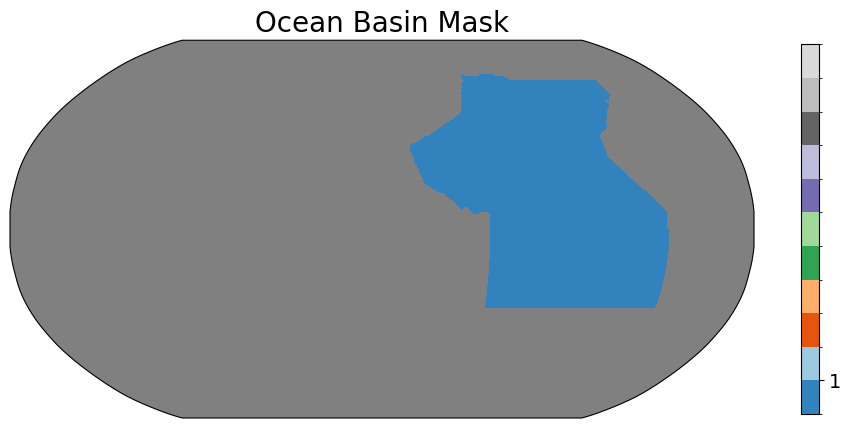

In [81]:
subplot_kws = dict(projection=ccrs.Robinson(central_longitude=-120),facecolor='grey')

plt.figure(figsize=[12,8])

p = atlanticocean.plot.contourf(x='lon',y='lat',
                         cmap='tab20c',
                         vmin=0,vmax=11,levels =12,
                         subplot_kws = subplot_kws,
                         transform=ccrs.PlateCarree(),
                         add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[1], shrink=0.6)
cb.ax.tick_params(labelsize=14)
plt.title("Ocean Basin Mask",fontsize=20)

Text(0.5, 1.0, 'Ocean Basin Mask')

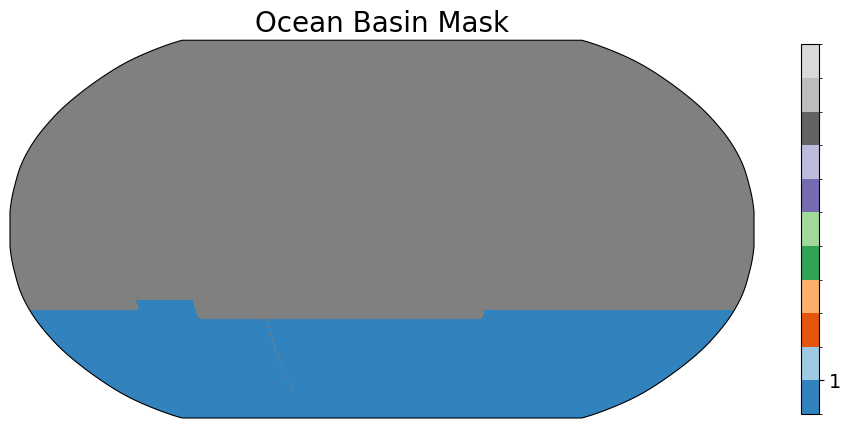

In [82]:
subplot_kws = dict(projection=ccrs.Robinson(central_longitude=-120),facecolor='grey')

plt.figure(figsize=[12,8])

p = southernocean.plot.contourf(x='lon',y='lat',
                         cmap='tab20c',
                         vmin=0,vmax=11,levels =12,
                         subplot_kws = subplot_kws,
                         transform=ccrs.PlateCarree(),
                         add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[1], shrink=0.6)
cb.ax.tick_params(labelsize=14)
plt.title("Ocean Basin Mask",fontsize=20)

### Now we can multiply our mask by the DataArray to isolate just the temperatures over a specific region:

In [89]:
woa18_1955_64_atlantic = woa18_1955_64_potential_temp*atlanticocean

In [91]:
woa18_1955_64_atlantic

<xarray.DataArray (depth: 102, lat: 180, lon: 360)>
dask.array<mul, shape=(102, 180, 360), dtype=float64, chunksize=(26, 45, 180), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    time     float32 438.0

Text(0.5, 1.0, 'SST Atlantic 1955 to 1964 averaged')

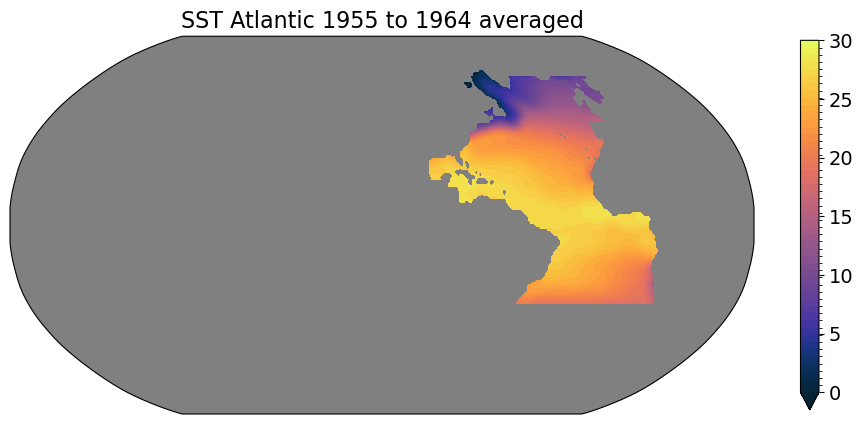

In [101]:
subplot_kws = dict(projection=ccrs.Robinson(central_longitude=-120),facecolor='grey')

plt.figure(figsize=[12,8])

p = woa18_1955_64_atlantic.isel(depth=0).plot.contourf(x='lon',y='lat',
                         cmap=cmocean.cm.thermal,
                         vmin=0,vmax=30,levels=50,
                         subplot_kws = subplot_kws,
                         transform=ccrs.PlateCarree(),
                         add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[0,5,10,15,20,25,30], shrink=0.6)
cb.ax.tick_params(labelsize=14)
plt.title("SST Atlantic 1955 to 1964 averaged",fontsize=16)

### The other files for your project include time series of observed __ocean heat content__, __steric sea level rise__, __thermosteric sea level rise__, and __halosteric sea level rise__ broken up into that computed over the top 700 m of the water column and over the upper 2000 m.

### This data is from: https://www.ncei.noaa.gov/access/global-ocean-heat-content/index.html

In [135]:
ocean_heat_content_0_2000 = xr.open_dataset('../data/heat_content_sea_level/heat_content_anomaly_0-2000_yearly.nc',
                                          decode_times=False)
ocean_heat_content_0_700 = xr.open_dataset('../data/heat_content_sea_level/heat_content_anomaly_0-700_yearly.nc',
                                          decode_times=False)

#### and so on ... there are more files!

### The climate model output can be retrieved via the same methods we worked through in Unit 7 --- please refer back to that tutorial for working with CMIP6 data on Google Cloud Store and make the appropriate selection in the catalog to get your GFDL-ESM4 historical Omon thetao data ....